### Chapter 3
# Classification
### MNIST
The MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.

Fetch the MNIST dataset:

In [1]:
import numpy as np

def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [2]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

Let's look at these arrays:

In [3]:
X, y =  mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). Let’s take a peek at one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a 28×28 array, and display it using Matplotlib’s imshow() function:

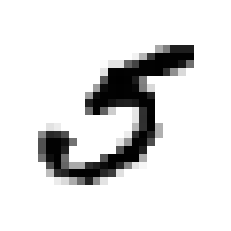

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

This looks like a 5, and indeed that’s what the label tells us:

In [6]:
y[36000]

5

Always create a test set and set it aside before inspecting the data closely. The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Training set should be shuffled, because:
- this will guarantee that all cross-validation folds will be similar
- some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row.


In [8]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Training a Binary Classifier
Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. A *binary classifier*, capable of distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for this classification task:

In [9]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

Start with a Stochastic Gradient Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This classifier has the advantage of being capable of handling very large datasets efficiently.  Let’s create an SGDClassifier and train it on the whole training set:

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now use it to detect images of the number 5:

In [11]:
sgd_clf.predict([some_digit])

array([ True])

The classifier guesses that this image represents a 5 (True).

# Performance Measures
Evaluating a classifier is often significantly trickier than evaluating a regressor

### Measuring Accuracy Using Cross-Validation
Let’s use the cross_val_score() function to evaluate your SGDClassifier model using K-fold cross-validation, with three folds:

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9653 , 0.91145, 0.965  ])

Above 95% accuracy (ratio of correct predictions) on all cross-validation folds? let’s look at a very dumb classifier that just classifies every single image in the “not-5” class:

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Model’s accuracy? Let’s find out:

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91075, 0.90965, 0.90855])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets.

### Confusion Matrix
A much better way to evaluate the performance of a classifier. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion matrix.

To compute Confusion matrix, need a set of predictions, so they can be compared to the actual targets. Use the cross_val_predict() function:

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean (means the predition is made by a model that never saw the data during training) prediction for each instance in the training set.

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[52473,  2106],
       [ 1059,  4362]], dtype=int64)

Each row in a confusion matrix represents an *actual class*, while each column represents a *predicted class*.

First row: Non-5s (*the negative class*):
- 53011 were correctly classified as non-5s: *true negatives*
- 1568 were wrongly classified as 5s: *false positives*

Second row: 5s (*the positive class*)
- 841 were wrongly classified as non-5s: *false negatives*
- 4580 were correctly classified as 5s: *true positives*

A perfect classifier would have only true positives and true negatives:

In [17]:
y_train_perfect_predictions = y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Precision and Recall
Scikit-Learn provides several functions to compute classifier metrics, including precision(*accuracy*: TP in FP+TP) and recall(*sensitivity*: TP in FN+RP):

In [18]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4580/ (4580 + 1568)

0.6743970315398887

In [19]:
recall_score(y_train_5, y_train_pred) # == 4580/ (4580 + 841)

0.8046485888212507

Now your 5-detector does not look as shiny as it did when you looked at its accuracy. When it claims an image represents a 5, it is correct only 74% of the time. Moreover, it only detects 84% of the 5s.

It is often convenient to combine precision and recall into a single metric called the F1 score. The F1 score is the harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values.

In [20]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7337875346959374

The F1 score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall.

Unfortunately, you can’t have it both ways: increasing precision reduces recall, an vice versa. This is called the *precision/recall tradeoff*.

### Precision/Recall Tradeoff
let’s look at how the SGDClassifier makes its classification decisions. For each instance, it computes a score based on a decision function, and if that score is greater than a threshold, it assigns the instance to the positive class, or else it assigns it to the negative class.

Instead of calling the classifier’s predict() method, you can call its decision_function() method, which returns a score for each instance, and then make predictions based on those scores using any threshold you want:

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([428.15451098])

In [22]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

y_some_digit_pred

array([ True])

The SGDClassifier uses a threshold equal to 0, so the previous code returns the same result as the predict() method (i.e., True). Let’s raise the threshold:

In [23]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)

y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 200,000.

So to decide which threshold to use. First need to get the scores of all instances in the training set using the cross_val_predict() function, specify it to return decision scores instead of predictions:

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                             method="decision_function")

Now with these scores you can compute precision and recall for all possible thresholds using the precision_recall_curve() function:

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finally, plot precision and recall as functions of the threshold value using Matplotlib:

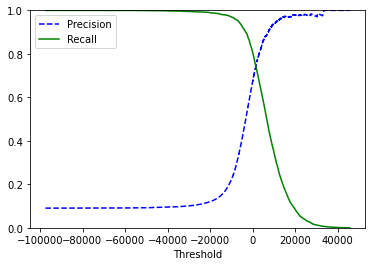

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Now select the threshold value that gives you the best precision/recall tradeoff for your task.

So let’s suppose you decide to aim for 90% precision. You look up the plot and find that you need to use a threshold of about 5,000. To make predictions, instead of calling the classifier’s predict() method, you can just run this code:

In [27]:
(y_train_pred == (y_scores > 0)).all()

True

In [28]:
y_train_pred_90 = (y_scores > 5000)

Let's check these predictions' precision and recall:

In [29]:
precision_score(y_train_5, y_train_pred_90)

0.8622392974753018

In [30]:
recall_score(y_train_5, y_train_pred_90)

0.5795978601733998

90% precision classifier! Easy to create a classifier with virtually any precision you want: just set a high enough threshold. A high-precision classifier is not very useful if its recall is too low!

Another way to select a good precision/recall tradeoff is to plot precision directly against recall.

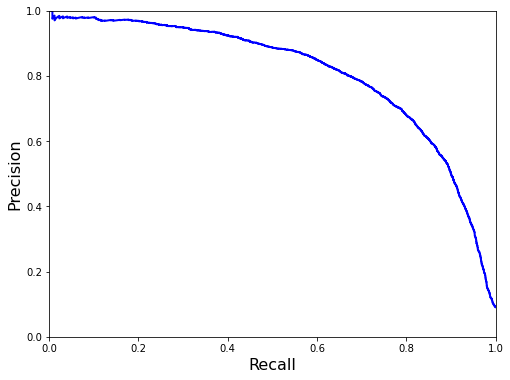

In [31]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
# save_fig("precision_vs_recall_plot")
plt.show()

Precision really starts to fall sharply around 80% recall. You will probably want to select a precision/recall tradeoff just before that drop.

### The ROC Curve
The *receiver operating characterstic* curve: similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate.

To plot the ROC curve, you first need to compute the TPR and FPR for various threshold values, using the roc_curve() function:

In [33]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Then plot the FPR against the TPR using Matplotlib:

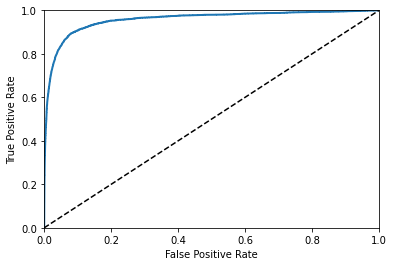

In [34]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

The higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible.

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC = 1, whereas a purely random classifier will have a ROC AUC = 0.5:

In [36]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9577083776070104

Let’s train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier. The RandomForestClassifier class does not have a decision_function() method. Instead it has a predict_proba() method. The predict_proba() method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class:

In [37]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                                    method="predict_proba")

But to plot a ROC curve, you need scores, not probabilities. A simple solution is to use the positive class’s probability as the score:

In [38]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Ready to plot the ROC curve:

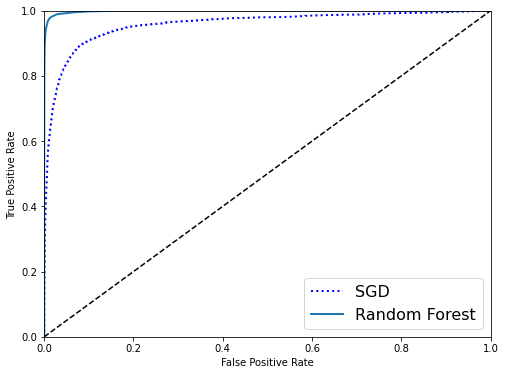

In [43]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
# save_fig("roc_curve_comparison_plot")
plt.show()

The RandomForestClassifier’s ROC curve looks much better than the SGDClassifier’s. As a result, its ROC AUC score is also significantly better:

In [42]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983703180325567

To train binary classifiers, choose the appropriate metric for your task, evaluate your classifiers using cross-validation, select the precision/recall tradeoff that fits your needs, and compare various models using ROC curves and ROC AUC scores.

# Multiclass Classification
Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are capable of handling multiple classes directly. Others (such as Support Vector Machine classifiers or Linear classifiers) are strictly binary classifiers. Or use to perform multiclass classification using multiple binary classifiers.

one way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers. Then when you want to classify an image, you get
the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the one-versus-all (OvA) strategy.

Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvA:

In [44]:
sgd_clf.fit(X_train, y_train)

sgd_clf.predict([some_digit])

array([5], dtype=int8)

This code trains the SGDClassifier on the training set using the original target classes from 0 to 9. 

To see, call the decision_function() method. Instead of returning just one score per instance, it now returns 10 scores, one per class:

In [45]:
some_digit_scores = sgd_clf.decision_function([some_digit])

some_digit_scores

array([[-10561.45284912, -25356.75457438,  -6016.91596864,
         -2490.27178069,  -9965.39223319,   3707.68255695,
        -24651.69851976, -13819.00809204, -13317.31618678,
        -21985.67414047]])

The highest score is indeed the one corresponding to class 5:

In [46]:
np.argmax(some_digit_scores)

5

In [47]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [49]:
sgd_clf.classes_[5]

5

If you want to force ScikitLearn to use one-versus-one or one-versus-all, you can use the OneVsOneClassifier or OneVsRestClassifier classes. Simply create an instance and pass a binary classifier to its constructor:

In [50]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [51]:
len(ovo_clf.estimators_)

45

Training a RandomForestClassifier is just as easy:

In [52]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

This time Scikit-Learn did not have to run OvA or OvO because Random Forest classifiers can directly classify instances into multiple classes. You can call predict_proba() to get the list of probabilities that the classifier assigned to each instance for each class:

In [53]:
forest_clf.predict_proba([some_digit])

array([[0.04, 0.02, 0.  , 0.09, 0.  , 0.83, 0.  , 0.01, 0.01, 0.  ]])

The 0.8 at the 5th index in the array means that the model estimates an 80% probability that the image represents a 5.

Let’s evaluate the SGDClassifier’s accuracy using the cross_val_score() function:

In [54]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87915, 0.86485, 0.85405])

It gets over 85% on all test folds. And scaling the inputs increases accuracy above 90%:

In [55]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

c:\Users\Kushan\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


array([0.89745, 0.90315, 0.9008 ])

# Error Analysis
Assume that you have found a promising model and you want to find ways to improve it. One way to do this is to analyze the types of errors it makes.

First, you can look at the confusion matrix. You need to make predictions using the cross_val_predict() function, then call the confusion_matrix():

In [56]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

c:\Users\Kushan\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


array([[5591,    0,   17,    9,    9,   44,   38,    7,  207,    1],
       [   1, 6418,   45,   20,    3,   45,    4,    8,  185,   13],
       [  24,   25, 5248,   86,   66,   27,   72,   39,  359,   12],
       [  23,   20,  104, 5263,    0,  209,   24,   39,  382,   67],
       [  14,   17,   42,    9, 5223,    8,   35,   24,  294,  176],
       [  30,   17,   23,  163,   52, 4457,   79,   17,  513,   70],
       [  30,   18,   46,    4,   42,   86, 5544,    6,  142,    0],
       [  17,   12,   49,   25,   47,   13,    6, 5715,  157,  224],
       [  19,   62,   37,   93,    2,  123,   31,   10, 5431,   43],
       [  21,   21,   32,   65,  127,   35,    1,  174,  335, 5138]],
      dtype=int64)

It’s often more convenient to look at an image representation of the confusion matrix, using Matplotlib’s matshow() function:

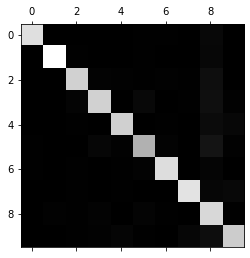

In [57]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Since most images are on the main diagonal, which means that they were classified correctly. The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits.

First divide each value in the confusion matrix by the number of images in the corresponding class, so you can compare error rates instead of absolute number of errors:

In [58]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Now let’s fill the diagonal with zeros to keep only the errors, and let’s plot the result:

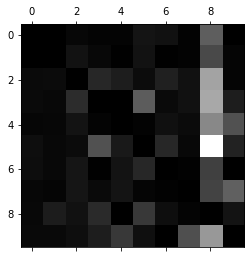

In [59]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Rows represent actual classes, while columns represent predicted classes. The columns for classes 8 is quite bright, which tells you that many images get misclassified as 8s. Similarly, the rows for classe 9 is also quite bright, telling you that 9s are often confused with other digits. Notice that the errors are not perfectly symmetrical; for example, there are more 5s misclassified as 8s than the reverse.

Analyzing individual errors can also be a good way to gain insights on what your classifier is doing and why it is failing, but it is more difficult and time-consuming. For example, let’s plot examples of 3s and 5s:

In [64]:
# EXTRA
import matplotlib as mpl

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

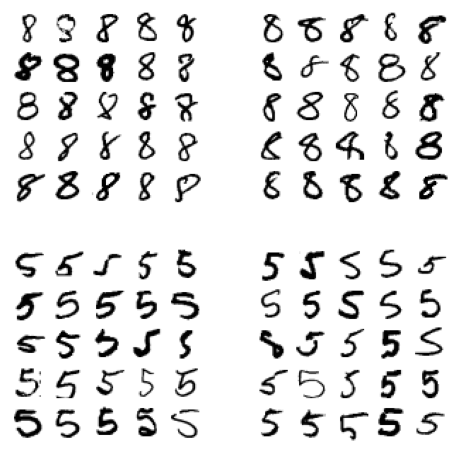

In [66]:
cl_a, cl_b = 8, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# Multilabel Classification
Until now each instance has always been assigned to just one class. In some cases you may want your classifier to output multiple classes for each instance. Say
the classifier has been trained to recognize three faces, Alice, Bob, and Charlie; then when it is shown a picture of Alice and Charlie, it should output [1, 0, 1], just for illustration purpose:

In [67]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

This code creates a y_multilabel array containing two target labels for each digit image. The next lines create a KNeighborsClassifier instance and we
train it using the multiple targets array. Now you can make a prediction, and notice that it outputs two labels:

In [68]:
knn_clf.predict([some_digit])

array([[False,  True]])

Now evaluate a multilabel classifier. One approach is to measure the F1 score for each individual label, then simply compute the average score:

In [69]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

0.9681001545125266

This assumes that all labels are equally important, which may not be the case. One simple option is to give each label a weight equal to its support. To do this, simply set average="weighted".

# Multioutput Classification
Generalization of multilabel classification where each label can be multiclass. Let’s build a system that removes noise from images. It will take as input a noisy digit image, and it will output a clean digit image.

Let’s start by creating the training and test sets by taking the MNIST images and adding noise to their pixel intensities using NumPy’s randint() function. The target images will be the original images:

In [71]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Let’s take a peek at an image from the test set :

In [73]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

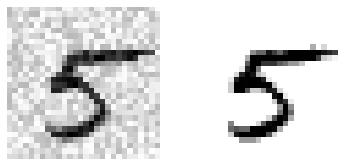

In [75]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
# save_fig("noisy_digit_example_plot")
plt.show()

On the left is the noisy input image, and on the right is the clean target image. Now let’s train the classifier and make it clean this image:

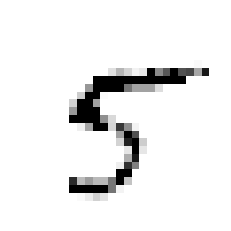

In [76]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)